<font color=skyblue size=6>  Final Project- Cognitive and psycological networks</font>

<font color=dodgerblue size=5>  Analysis of bullying tweets in comparison to non bullying tweets with network approach</font>

## step 1: importing the dataset
    

In [1]:
import nltk


In [2]:
import pandas as pd

# Read the CSV file into a pandas dataframe
df = pd.read_csv("cyberbullying_tweets.csv")
df = df.drop_duplicates(subset='tweet_text')

df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


### checking occurence of bullying types

In [3]:
label_distribution = df['cyberbullying_type'].value_counts()
label_distribution

religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: cyberbullying_type, dtype: int64

### creating bullying and non bullying datasets

In [4]:
bull_types = ["age", "ethnicity", "gender", "other_cyberbullying"]
df_bull = df[df["cyberbullying_type"].isin(bull_types)]
df_bull = df_bull[df_bull['tweet_text'].str.len()>=100] #think of selecting randomly less posts
df_bull = df_bull.sample(n=3000, random_state=1)  # Adjust the random_state if desired
df_bull

,tweet_text,cyberbullying_type
44298,"(Acts 29:21450) AND their ""wannabe white"" ento...",ethnicity
12025,I’m literally watching the female jump out thi...,gender
47213,"No place for racism in Islam, #ReduceInternetP...",ethnicity
30178,RT @KimKardashian: Everything should have an e...,other_cyberbullying
41062,If I learned anything this past couple weeks. ...,ethnicity
...,...,...
9131,Sometimes it’s better to just close your mouth...,gender
24867,RT @VeronicaGriman: Idiot Dan Rather Lambastes...,other_cyberbullying
36088,Was not a bully (got bullied) but I definitely...,age
32157,I stood up bullies in high school. I started a...,age


In [5]:
df_not_bull = df[df["cyberbullying_type"]=="not_cyberbullying"]
df_not_bull = df_not_bull[df_not_bull['tweet_text'].str.len()>=100]
df_not_bull.shape

(2949, 2)

## step 2- constructing the networks

### constructing the first nework: whole posts as nodes,their cosine similarity as edges

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def construct_tweet_network(df):
    # Create a TfidfVectorizer to convert tweet text into a matrix of token counts
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df["tweet_text"])
    
    # Compute the cosine similarity between tweet vectors
    cosine_similarities = cosine_similarity(X)
    
    # Create a graph where nodes represent tweets and edges represent cosine similarity
    G = nx.Graph()
    
    # Add tweets as nodes to the graph
    for i, tweet in enumerate(df["tweet_text"]):
        G.add_node(i, tweet=tweet)
    

    # Add edges to the graph based on cosine similarity
    num_tweets = len(df)
    for i in range(num_tweets):
        for j in range(i+1, num_tweets):
            similarity = cosine_similarities[i, j]
            if similarity > 0.6:  # Set a threshold for edge creation
                G.add_edge(i, j, weight=similarity)
    # Remove self-loop nodes and edges
    self_loop_nodes = list(nx.nodes_with_selfloops(G))
    G.remove_nodes_from(self_loop_nodes)
    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
   
    return G


def network_visualiation(G):
    # Visualize the network
    plt.figure(figsize=(10, 10))
    pos = nx.circular_layout(G)  

    # Ssetting the widths of the edges based on their weight (similarity)
    edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = np.array(edge_widths)
    edge_widths = (edge_widths - edge_widths.min()) / np.sum(edge_widths) *200


    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=80)

    nx.draw_networkx_edges(G, pos, edge_color='Steelblue',alpha=0.9, width=edge_widths)

    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.axis("off")
    plt.show()
    
    

In [7]:
G_all_tweets_bull=construct_tweet_network(df_bull)
G_all_tweets_not_bull=construct_tweet_network(df_not_bull)


Bullying Tweets network:


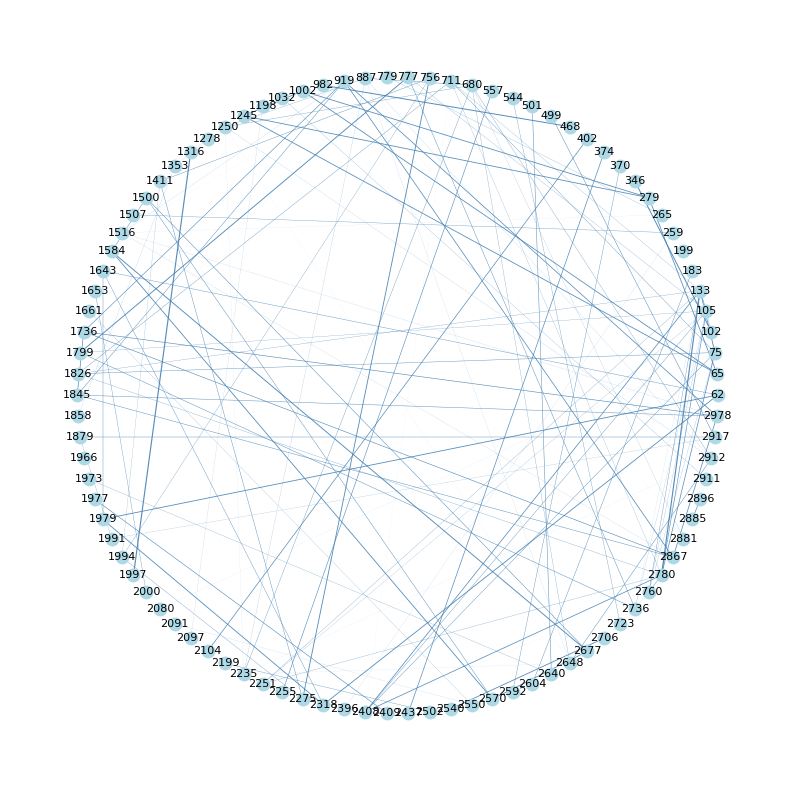

In [8]:
print("Bullying Tweets network:")
network_visualiation(G_all_tweets_bull)

Non-Bullying Tweets network:


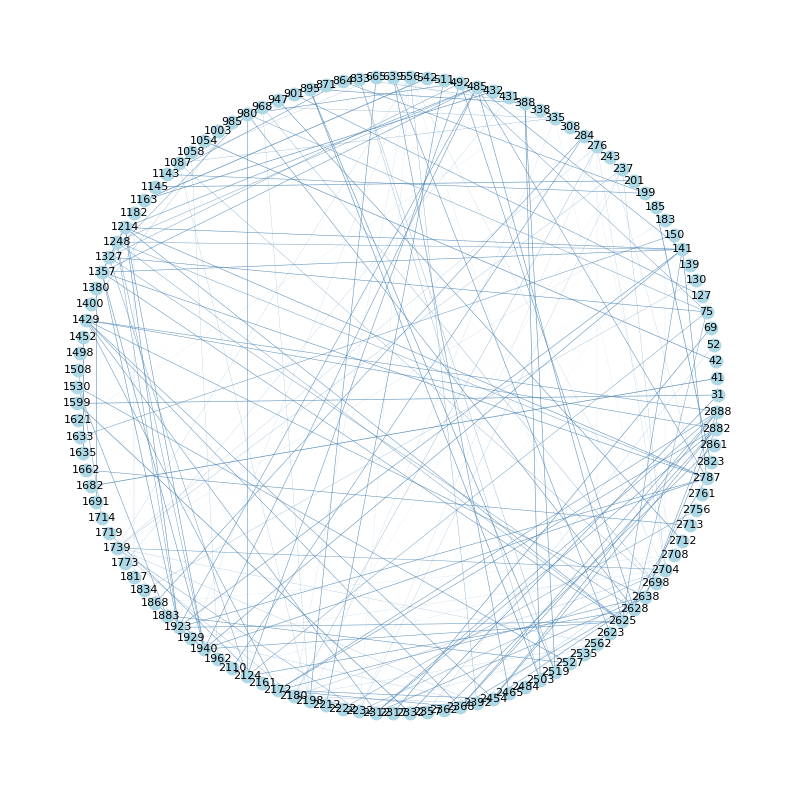

In [9]:
print("Non-Bullying Tweets network:")
network_visualiation(G_all_tweets_not_bull)

In [10]:
(G_all_tweets_bull.number_of_nodes(),G_all_tweets_bull.number_of_edges())

(94, 129)

In [11]:
(G_all_tweets_not_bull.number_of_nodes(),G_all_tweets_not_bull.number_of_edges())

(119, 197)

### constructing the second type neworks: network for each post, words as nodes, their cosine similarity as edges

In [12]:
#working great on the posts, also logical correct, but the posts alone aren't strong enough
#add: remove nodes+ edges that are in self loops
import pandas as pd
import fasttext.util
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


# Load FastText word vectors
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

# Get the English stopwords
stopwords = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

colors = ['red', 'blue', 'green', 'pink', 'orange', 'purple']

def build_semantical_networks(df):
    networks_list=[]
    for index, row in df.iterrows():
        tweet_text = row["tweet_text"]

        # Removing URLs from the tweet_text
        tweet_text = re.sub(r"http\S+|www\S+|https\S+", "", tweet_text)

        # Tokenize the tweet_text into words
        words = word_tokenize(tweet_text)

        preprocessed_words = []
        for word in words:
            # Remove punctuation and non-alphabetic characters
            word = re.sub(r"[^\w\s]", "", word) # converting special symbols to regular expressions
            if not word.isalpha():
                continue
            # Convert the word to lowercase and singular form
            word = lemmatizer.lemmatize(word.lower())
            # Filter out non-English words
            if word not in stopwords:
                preprocessed_words.append(word)

        # Calculate word embeddings for each word
        embeddings = [ft.get_word_vector(word) for word in preprocessed_words]

        # Compute the cosine similarity between each pair of words
        cosine_similarities = cosine_similarity(embeddings)

        G = nx.Graph()
        for i in range(len(preprocessed_words)):
            for j in range(i + 1, len(preprocessed_words)):
                if cosine_similarities[i, j] > 0.6:  # Set a threshold for edge creation
                    G.add_edge(preprocessed_words[i], preprocessed_words[j], weight=cosine_similarities[i, j])

        if G.number_of_nodes()<10:
            continue

        else:
            # Remove self-loop nodes and edges
            self_loop_nodes = list(nx.nodes_with_selfloops(G))
            G.remove_nodes_from(self_loop_nodes)
            # Remove isolated nodes
            isolated_nodes = list(nx.isolates(G))
            G.remove_nodes_from(isolated_nodes)
            networks_list.append(G)
    return networks_list
            
def visualize_network(networks_list):
    i=0
    for G in networks_list: 
        pos = nx.circular_layout(G)  
        plt.figure(figsize=(8, 8))

        color = colors[i % len(colors)]

        nx.draw_networkx_nodes(G, pos, node_size=10)

        nx.draw_networkx_edges(G, pos,edge_color=color)

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)

        nx.draw_networkx_labels(G, pos, font_weight='bold',font_color=color)

        plt.axis('off')
        plt.show()    
        i +=1

## generating posts from a whole text

#### note: I performed several executions of this code and concluded our final results. in order to keep the data in the final results like in the notebook I stored the last execution into a csv and loaded it so we'll not accidentaly change the data

In [13]:
import random
# Sample 1000 tweets with 500 words
tweet_length = 500
num_tweets = 1000

def get_words_list(df):
    # Concatenate all the posts together
    concatenated_text = ' '.join(df["tweet_text"].tolist())

    # Split the concatenated text into individual words
    words_list = concatenated_text.split()

    return words_list

def sample_tweets(words_list):
    sampled_tweets=[]
    while len(sampled_tweets) < num_tweets:
        if len(words_list) < tweet_length:
            break
        tweet = ' '.join(words_list[:tweet_length])
        sampled_tweets.append(tweet)
        words_list = words_list[tweet_length:]

    # Shuffle the sampled tweets
    random.shuffle(sampled_tweets)

    # Keep only the first 1000 sampled tweets
    sampled_tweets = sampled_tweets[:num_tweets]
    
    # Create a new dataframe with the sampled tweets
    df_sampled = pd.DataFrame({"tweet_text": sampled_tweets})
    
    return df_sampled

# Group DataFrame by 'cyberbullying_type' and apply your functions to each group
grouped_by_bull_type_df = df.groupby('cyberbullying_type')

sampled_dfs = []

for name, group in grouped_by_bull_type_df:
    words_list = get_words_list(group)
    sampled_df = sample_tweets(words_list)
    sampled_df['cyberbullying_type'] = name  # add the cyberbullying type to the sampled DataFrame
    sampled_dfs.append(sampled_df)

# Concatenate all the sampled DataFrames
sampled_tweets_df = pd.concat(sampled_dfs, ignore_index=True)

In [14]:
sampled_tweets_df

,tweet_text,cyberbullying_type
0,gets bullied in high school. People keep telli...,age
1,this woman was giving a presentation to my cla...,age
2,murder. And they didn’t even go after their su...,age
3,people as an adult. Waiting tables was way wor...,age
4,at my school crush the “bully” and light him u...,age
...,...,...
2206,the wings of my cat eyes when I offer a little...,religion
2207,"ally, to the white house...and he declared him...",religion
2208,Corona try to eliminate cruelty of Radical isl...,religion
2209,is a muslim. :) No one can throw the race card...,religion


### tweets networks of bullying tweets

In [15]:
sampled_tweets_df_bull = sampled_tweets_df[sampled_tweets_df["cyberbullying_type"].isin(bull_types)]
sampled_tweets_df_bull

,tweet_text,cyberbullying_type
0,gets bullied in high school. People keep telli...,age
1,this woman was giving a presentation to my cla...,age
2,murder. And they didn’t even go after their su...,age
3,people as an adult. Waiting tables was way wor...,age
4,at my school crush the “bully” and light him u...,age
...,...,...
1672,with twitter. if it's urgent or twitter's abus...,other_cyberbullying
1673,familiar is much higher than that of a new lan...,other_cyberbullying
1674,like a dick. #mkr I feel bad that Greyson got ...,other_cyberbullying
1675,I did offer :P awh I'm sure you're bullying so...,other_cyberbullying


In [16]:
bull_semantical_networks= build_semantical_networks(sampled_tweets_df_bull)

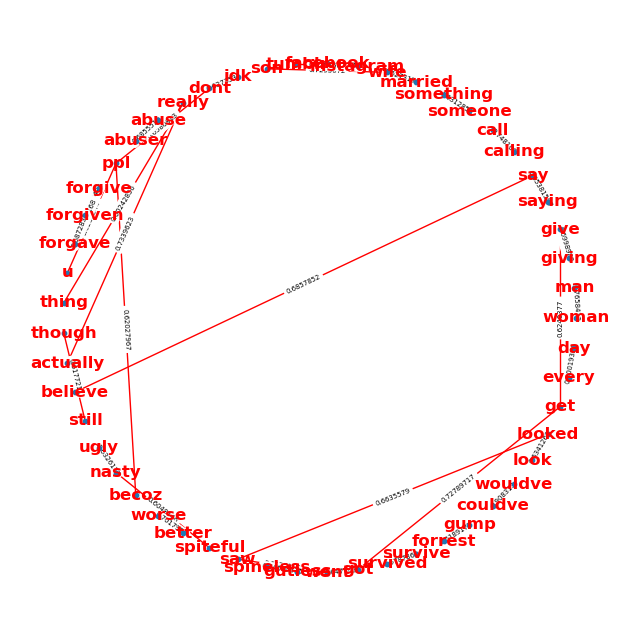

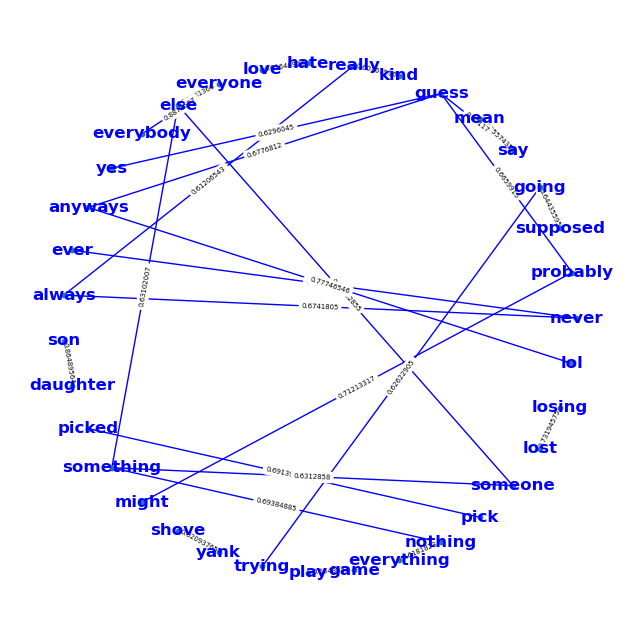

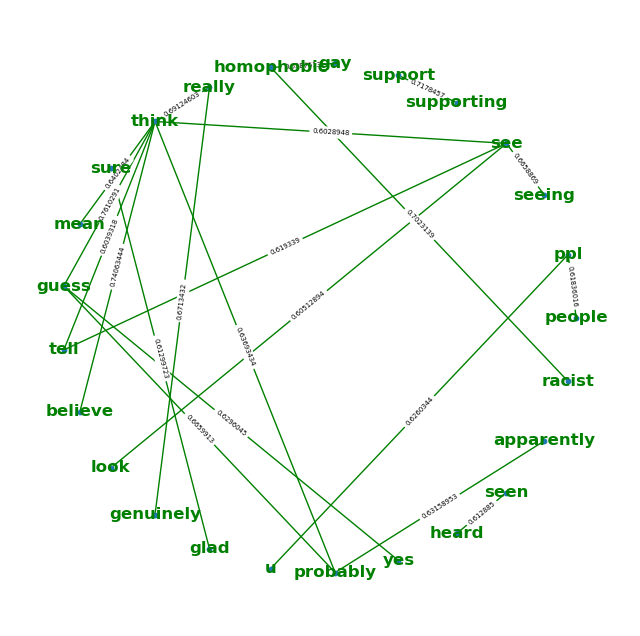

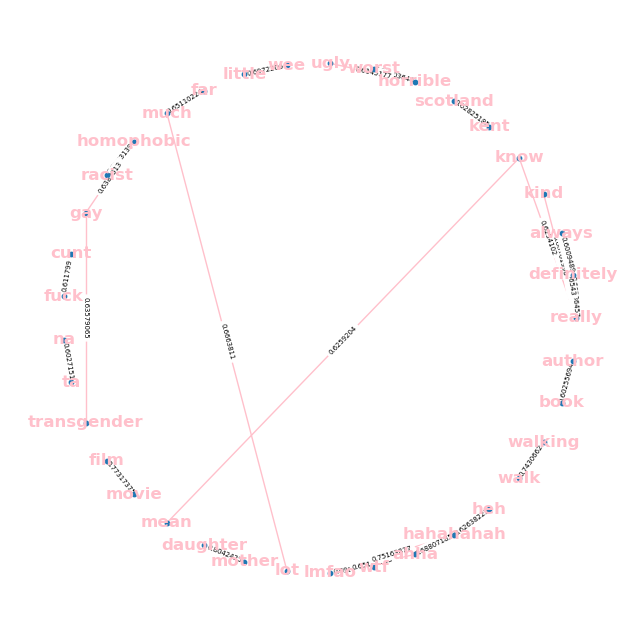

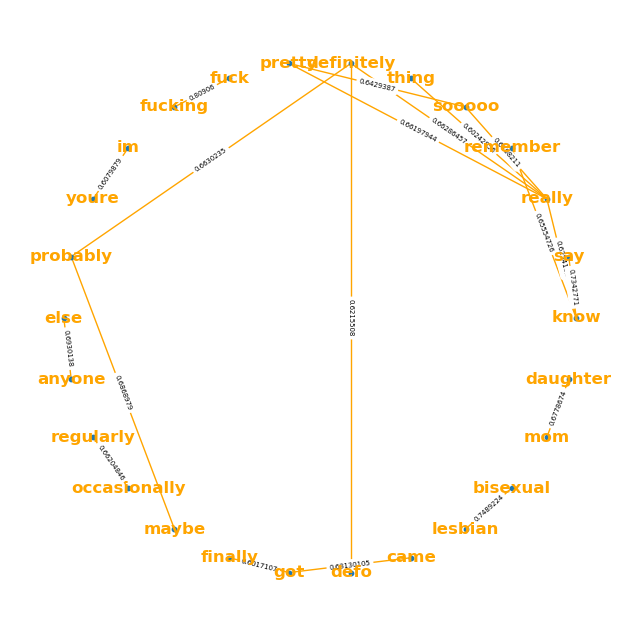

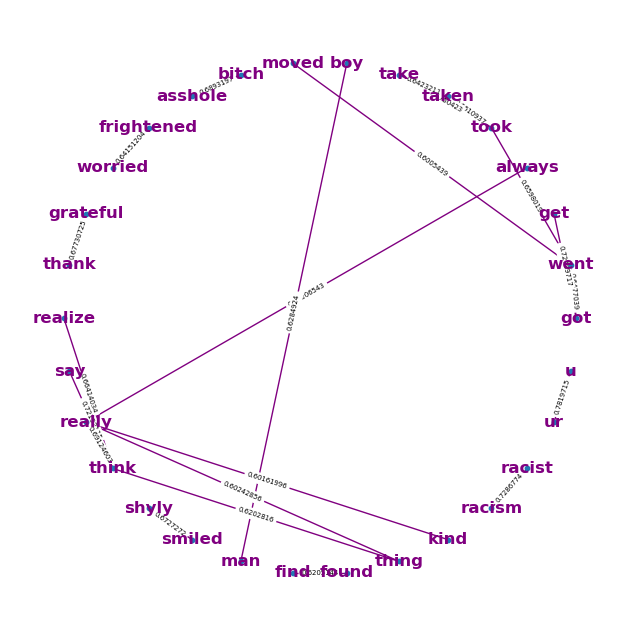

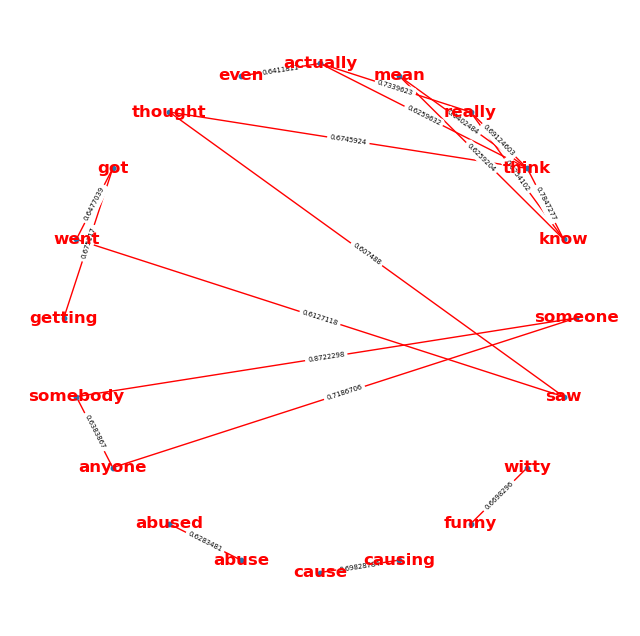

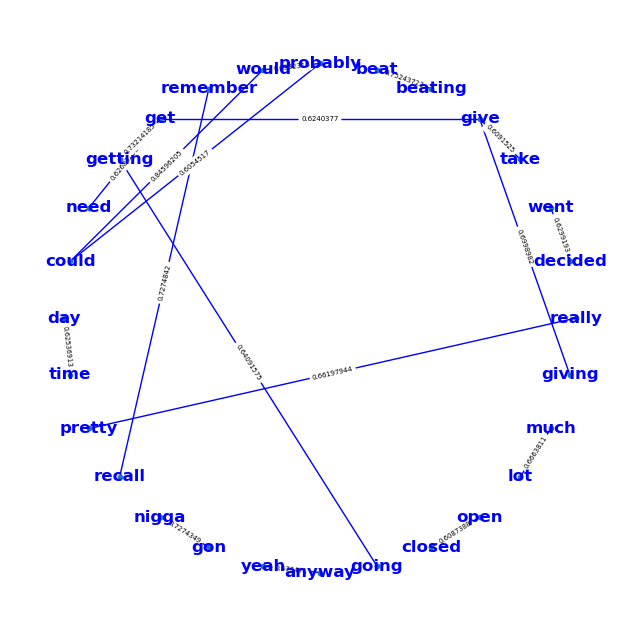

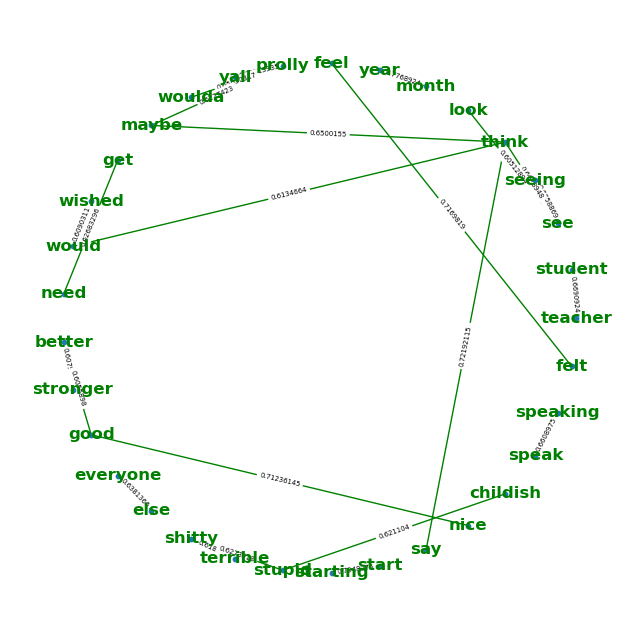

In [17]:
visualize_network(bull_semantical_networks[1:10])

### tweets networks of non bullying tweets

In [18]:
sampled_tweets_df_not_bull = sampled_tweets_df[sampled_tweets_df["cyberbullying_type"]=="not_cyberbullying"]
sampled_tweets_df_not_bull


,tweet_text,cyberbullying_type
1285,RT @BastendorfGames @maxcaras I'm no sexist ei...,not_cyberbullying
1286,to follow suit. March to the beat of my own Dr...,not_cyberbullying
1287,would of been funnier if those two bottom team...,not_cyberbullying
1288,@1Protoco1_J1had @ALWiss5 @ISdawah300 Guy make...,not_cyberbullying
1289,like breakfast ?!?! #mkr Hope you do okay XD @...,not_cyberbullying
...,...,...
1496,couple. Can't believe how disgusted I am in th...,not_cyberbullying
1497,date. #KeepItClassy It doesn't surprise me tha...,not_cyberbullying
1498,pro show o: @truaemusic ...tries to make it ab...,not_cyberbullying
1499,This will be my first rainy day at SFSU 😁😩😕 TI...,not_cyberbullying


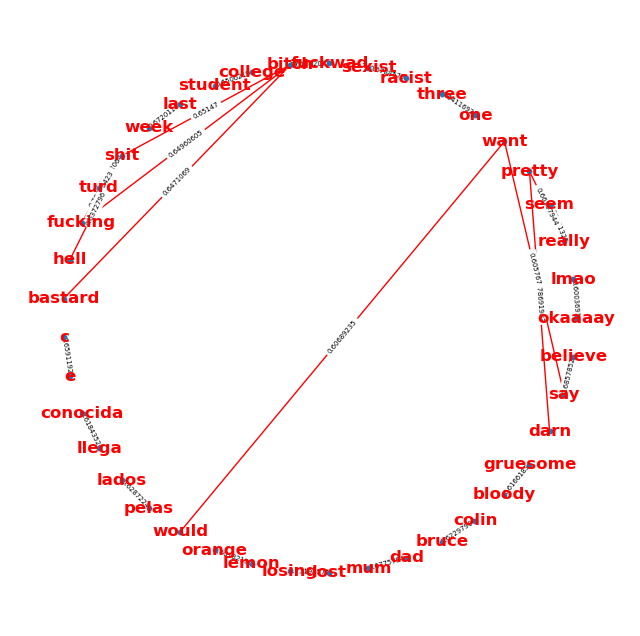

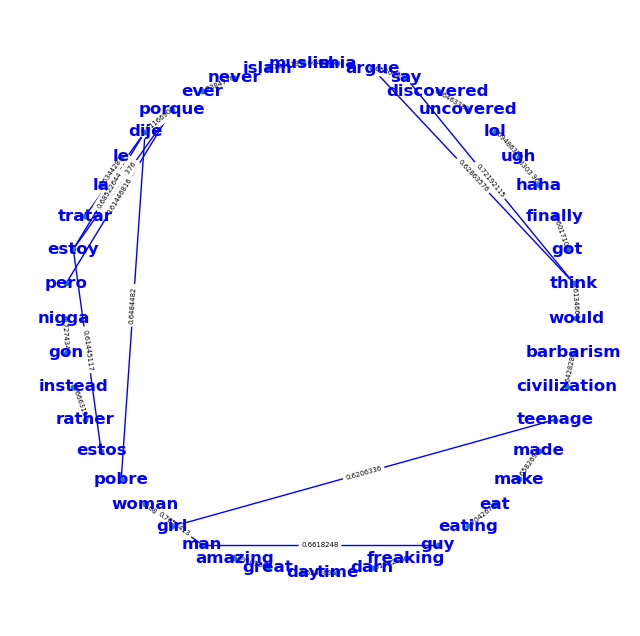

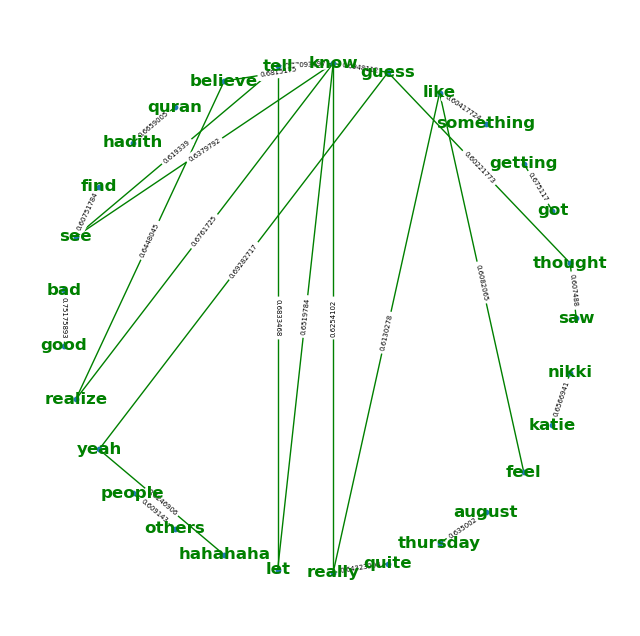

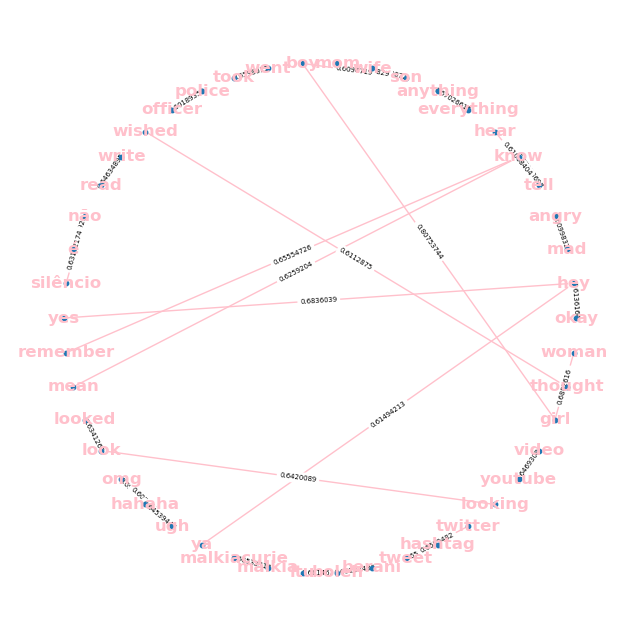

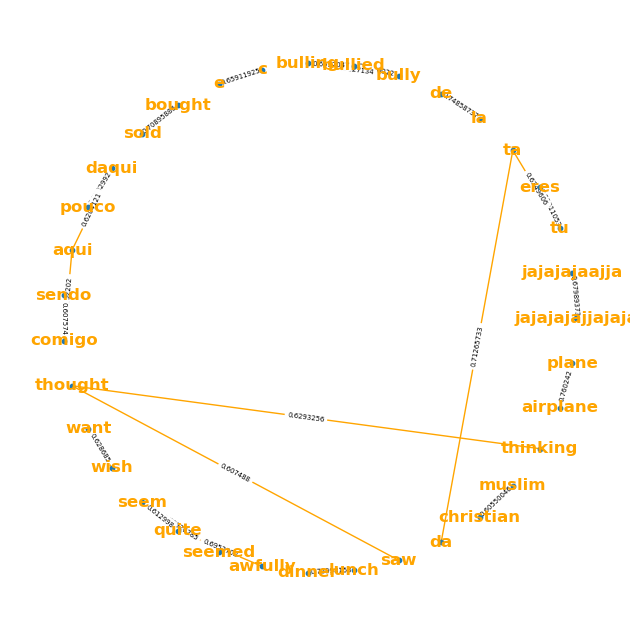

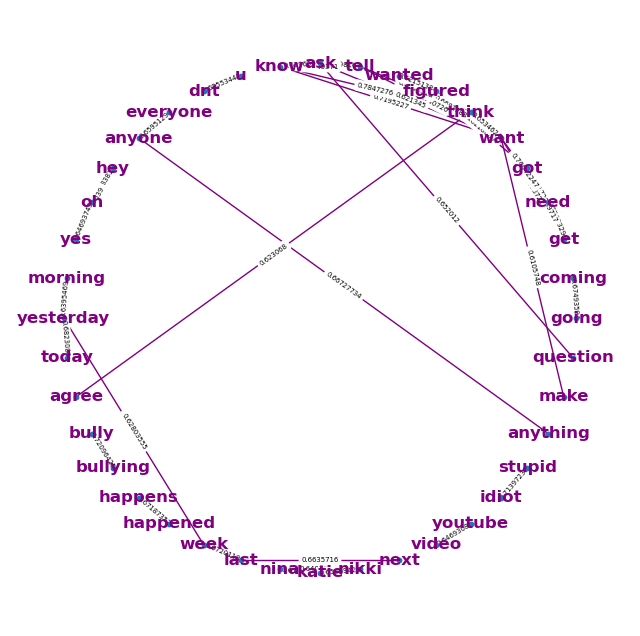

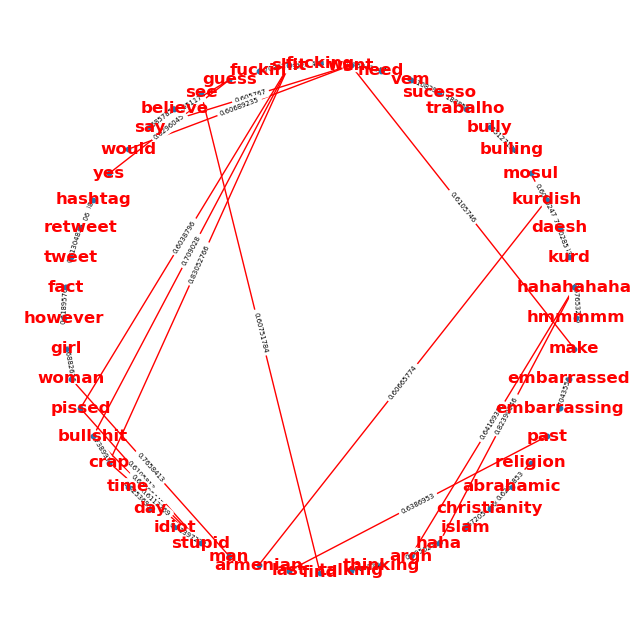

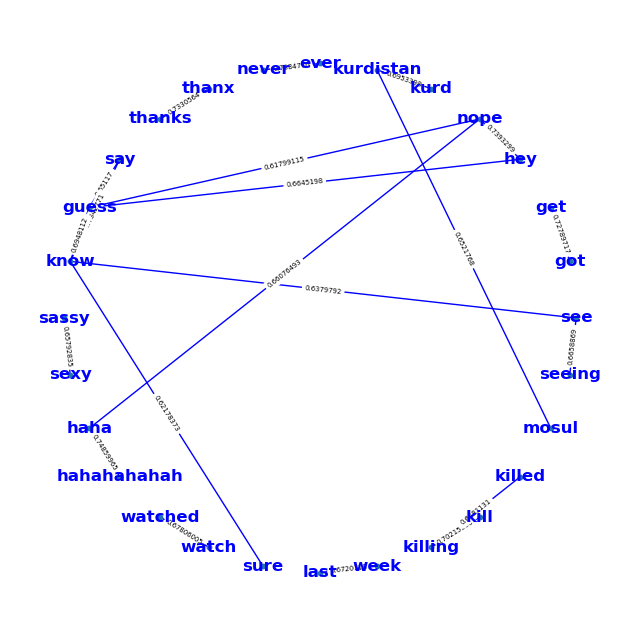

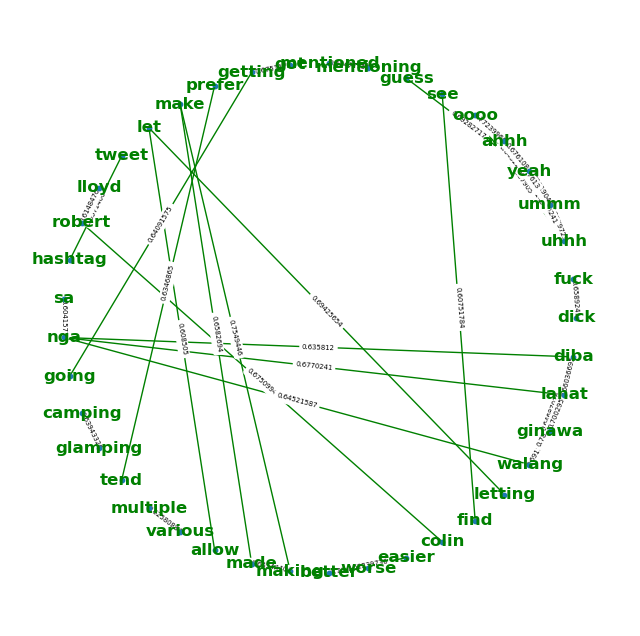

In [19]:
non_bull_semantical_networks= build_semantical_networks(sampled_tweets_df_not_bull)
visualize_network(non_bull_semantical_networks[1:10])

## Step 3- Networks Analysis

### network 1- tweets as nodes

### first research question- compute metrics to find most influential nodes in networks and their topics

In [20]:
import networkx as nx

def get_top_nodes(G, centrality_measure, top_n=10):
    centrality = centrality_measure(G)
    sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
    top_nodes = sorted_nodes[:top_n]
    print(f"Top 10 nodes with the highest {centrality_label}:")
    print(top_nodes)
    return top_nodes

def print_nodes_with_tweet_text(G, node_list):
    for node in node_list:
        if node in G.nodes:
            tweet_text = G.nodes[node]['tweet']
            print("Node {}: {}".format(node, tweet_text),"\n")

        
def find_common_numbers(lists):
    sets = [set(lst) for lst in lists]
    common_numbers = set.intersection(*sets)
    return list(common_numbers)

        
networks = [('Bullying Network', G_all_tweets_bull), ('Non-Bullying Network', G_all_tweets_not_bull)]

centrality_measures = [(nx.degree_centrality, 'Degree Centrality'),
                       (nx.pagerank, 'PageRank Centrality'),
                       (nx.closeness_centrality, 'Closeness Centrality')]


### finding intersection between the 3 measures

#### Bullyign Network

In [21]:
#finding top nodes for bullying network
top_nodes_list_bull = []
print("Bullying Network :")
for centrality_measure, centrality_label in centrality_measures:
    top_nodes = get_top_nodes(G_all_tweets_bull, centrality_measure)
    top_nodes_list_bull.append(top_nodes)
    print("----------------------------------------")

common_nodes_bull = find_common_numbers(top_nodes_list_bull)
print(f"Common nodes in all measures in the Bullying Network:")
print(common_nodes_bull)

Bullying Network :
Top 10 nodes with the highest Degree Centrality:
[75, 105, 133, 2780, 2408, 680, 887, 1250, 2912, 711]
----------------------------------------
Top 10 nodes with the highest PageRank Centrality:
[259, 75, 133, 2780, 2917, 105, 2640, 1353, 1278, 2408]
----------------------------------------
Top 10 nodes with the highest Closeness Centrality:
[75, 105, 133, 2780, 2408, 2251, 2760, 2736, 711, 1826]
----------------------------------------
Common nodes in all measures in the Bullying Network:
[133, 2408, 105, 75, 2780]


In [22]:
print_nodes_with_tweet_text(G_all_tweets_bull,common_nodes_bull)

Node 133: #Racism is when u select your White clothes to wash first before the Black colored ones... Don't be a racist! Wash them all together 

Node 2408: LMAO RT @2shorth: Racism is when u select ur white clothes to wash before d black colored ones. Don't be a racist; wash them all together 

Node 105: Racism is wen u select ur White clothes to wash first b4 the Black Colored ones... Don't be a racist! Wash them all together #teamObama2012 

Node 75: Racism is when u select yur white clothes to wash first before the black and colored ones....Don't be a racist! Wash them all 2gether!!. 

Node 2780: Racism is when u select your White clothes to wash first before the Black/ Colored ones... Don't be a racist! Wash them all together 



#### Non Bullyign Network

In [23]:
#finding top nodes for bullying network
top_nodes_list_non_bull = []
print("Non Bullying Network :")
for centrality_measure, centrality_label in centrality_measures:
    top_nodes = get_top_nodes(G_all_tweets_not_bull, centrality_measure)
    top_nodes_list_non_bull.append(top_nodes)
    print("----------------------------------------")

common_nodes_non_bull = find_common_numbers(top_nodes_list_non_bull)
print(f"Common nodes in all measures in the Non Bullying Network:")
print(common_nodes_non_bull)

Non Bullying Network :
Top 10 nodes with the highest Degree Centrality:
[1739, 2704, 2232, 141, 485, 556, 1214, 1248, 1357, 1923]
----------------------------------------
Top 10 nodes with the highest PageRank Centrality:
[1739, 2704, 2232, 1621, 968, 1087, 2180, 2392, 556, 335]
----------------------------------------
Top 10 nodes with the highest Closeness Centrality:
[1739, 2704, 2232, 556, 2180, 2392, 2562, 276, 237, 1929]
----------------------------------------
Common nodes in all measures in the Non Bullying Network:
[2704, 1739, 556, 2232]


In [24]:
print_nodes_with_tweet_text(G_all_tweets_not_bull,common_nodes_non_bull)

Node 2704: @MisGrace @GBabeuf @RJennromao @DavidJo52951945 @Novorossiyan @gbazov @NewsCoverUp @rougek68 Good night. 

Node 1739: @MisGrace @GBabeuf @RJennromao @DavidJo52951945 @Novorossiyan @gbazov @NewsCoverUp @rougek68 No it doesn't. 

Node 556: @MisGrace @GBabeuf @RJennromao @DavidJo52951945 @Novorossiyan @gbazov @NewsCoverUp @rougek68 Russia, all media controlled by criminal Putin. 

Node 2232: @MisGrace @GBabeuf @RJennromao @DavidJo52951945 @Novorossiyan @gbazov @NewsCoverUp @rougek68 http://t.co/stp5NmjZRY 



### second research question- find the communities and their topics and discover the diversity of the networks' topics 

In [25]:
import community as community_louvain
from sklearn.decomposition import NMF

In [26]:
import matplotlib.cm as cm


color_palettes = ["Blues", "Oranges", "Purples_r", "Greens", "Reds", "pink"]
colors = [plt.get_cmap(name)(0.5) for name in color_palettes]

def compute_and_visualize_communities(G):
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)

    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    color_map = [colors[community % len(colors)] for community in partition.values()]

    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, node_color=color_map)
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    for community in set(partition.values()):
        plt.plot([], color=colors[community % len(colors)], label=f"Community {community}")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

    communities_dict = {}
    for node, community in partition.items():
        if community not in communities_dict:
            communities_dict[community] = []
        communities_dict[community].append(node)

    communities_dict = dict(sorted(communities_dict.items()))

    return partition, communities_dict, modularity



#### Plotting the communities

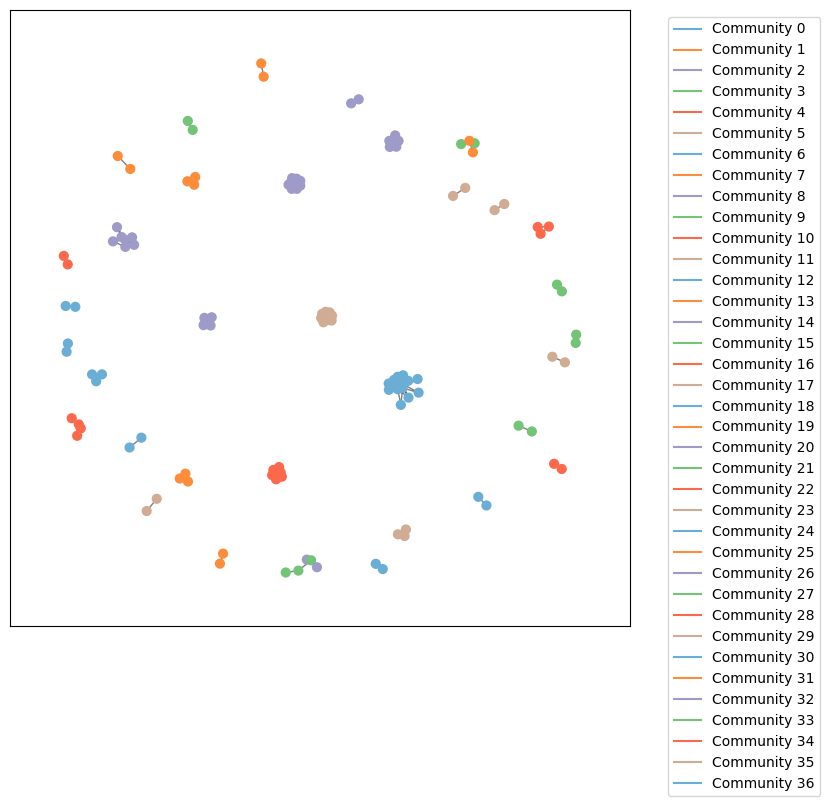

In [27]:
communities_partition_non_bull, communities_dict_non_bull,modularity_score_non_bull = compute_and_visualize_communities(G_all_tweets_not_bull)


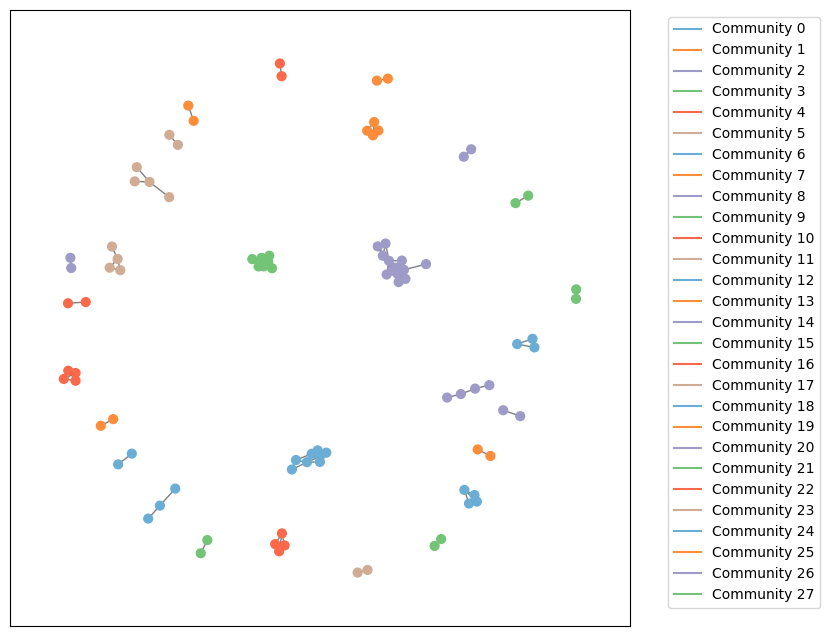

In [28]:
communities_partition_bull, communities_dict_bull,modularity_score_bull = compute_and_visualize_communities(G_all_tweets_bull)

### finding modularity score for both data sets

In [29]:
print("modularity score bullying tweets", modularity_score_bull,"modularity score non bullying tweets", modularity_score_non_bull)

modularity score bullying tweets 0.8680052674639873 modularity score non bullying tweets 0.8808472558737166


### observing the different communitiy nodes for each network type- bullying vs. non-bullying


In [30]:
for community, nodes in communities_dict_bull.items():
        print(f"Community {community}: Nodes {nodes}")

Community 0: Nodes [62, 1643, 1979, 2318]
Community 1: Nodes [65, 279, 1002, 1245]
Community 2: Nodes [75, 105, 133, 711, 777, 1799, 1826, 2080, 2251, 2408, 2736, 2760, 2780]
Community 3: Nodes [102, 346]
Community 4: Nodes [183, 2604]
Community 5: Nodes [199, 259, 1507, 2396]
Community 6: Nodes [265, 779, 919, 1516, 1736, 1845, 2867, 2978]
Community 7: Nodes [370, 2592]
Community 8: Nodes [374, 2437]
Community 9: Nodes [402, 2104]
Community 10: Nodes [468, 982]
Community 11: Nodes [499, 1879, 1991, 2917]
Community 12: Nodes [501, 1973, 2640]
Community 13: Nodes [544, 2723]
Community 14: Nodes [557, 2255]
Community 15: Nodes [680, 887, 1250, 2235, 2648, 2881, 2912]
Community 16: Nodes [756, 1411, 1994, 2275]
Community 17: Nodes [2885, 2896]
Community 18: Nodes [1032, 2911]
Community 19: Nodes [1198, 2097]
Community 20: Nodes [1278, 1353, 1858, 1966]
Community 21: Nodes [1316, 1997]
Community 22: Nodes [1500, 1584, 2570, 2677]
Community 23: Nodes [1653, 2000]
Community 24: Nodes [1661, 

In [31]:
for community, nodes in communities_dict_non_bull.items():
        print(f"Community {community}: Nodes {nodes}")

Community 0: Nodes [947, 2712]
Community 1: Nodes [41, 1682]
Community 2: Nodes [335, 665, 968, 1087, 2198, 2535, 2698]
Community 3: Nodes [42, 1054]
Community 4: Nodes [1058, 1962]
Community 5: Nodes [432, 542, 1163]
Community 6: Nodes [1182, 1817]
Community 7: Nodes [130, 1834]
Community 8: Nodes [141, 485, 1214, 1248, 1357, 1923, 1940, 2625, 2787]
Community 9: Nodes [985, 1400]
Community 10: Nodes [1452, 1635]
Community 11: Nodes [150, 1633]
Community 12: Nodes [185, 2823]
Community 13: Nodes [199, 864, 1143]
Community 14: Nodes [201, 1145]
Community 15: Nodes [1380, 1691]
Community 16: Nodes [243, 2761]
Community 17: Nodes [1508, 1714]
Community 18: Nodes [1530, 1883, 2527]
Community 19: Nodes [308, 871]
Community 20: Nodes [284, 1868, 2110, 2708]
Community 21: Nodes [338, 1621, 2484]
Community 22: Nodes [75, 492, 980, 1327, 2124, 2628]
Community 23: Nodes [431, 1773]
Community 24: Nodes [1719, 2161]
Community 25: Nodes [2222, 2756]
Community 26: Nodes [69, 2317]
Community 27: Node

In [32]:
def print_community_tweets(G, communities_dict):
    for community, nodes in communities_dict.items():
        print(f"\nCommunity {community}:\n")
        for node in nodes:
            print(f"Node {node} tweet:\n {G.nodes[node]['tweet']}\n")



### printing the tweets for each comunity

In [33]:
print("Non-Bullying community tweets")
print_community_tweets(G_all_tweets_not_bull, communities_dict_non_bull)

Non-Bullying community tweets

Community 0:

Node 947 tweet:
 @AlMonitor And if Daesh loose half their forces to air strikes while taking small villages, to say, "not weakened" is absurd.

Node 2712 tweet:
 @DerekBisaccio And if Daesh loose half their forces to air strikes while taking small villages, to say, "not weakened" is absurd.


Community 1:

Node 41 tweet:
 If your benchmark for success is Team Greek next door, then you're always going to be feeling confident. #MKR

Node 1682 tweet:
 If your benchmark for success is Team Greek next door, then you're always going to be feeling confident.


Community 2:

Node 335 tweet:
 Quem mais sofre bullying: ( ) Loiras burras. ( ) Nerds. (X) O número “24” da chamada. -&gt; @luuizaum DHUASHUDSAHUDAHSU

Node 665 tweet:
 Read my response to "Quem mais sofre bullying: ( ) Loiras burras. ( ) Nerds. (X) O número “24” da chamada. ja…": http://4ms.me/pfcPAo

Node 968 tweet:
 Quem mais sofre bullying: - › ( ) Loiras burras. › › ( ) Nerds. › › (X) O 

In [34]:
print("Bullying community tweets")
print_community_tweets(G_all_tweets_bull, communities_dict_bull)

Bullying community tweets

Community 0:

Node 62 tweet:
 #MileyCyrus Miley Cyrus causes controversy with date-rape 'joke' at GAY club gig in London http://ift.tt/1jm2uyJ

Node 1643 tweet:
 #MileyCyrus Miley Cyrus causes controversy with date-rape 'joke' at GAY club gig in London http://ift.tt/1l3jfBf'joke'-at-GAY-club-gig-in-London&amp;c=2ANoySojn758d6ckAcbPgEIBE3n0xG-Z3i4i-MK56ko&amp;mkt=en-us

Node 1979 tweet:
 #MileyCyrus Miley Cyrus causes controversy with date-rape 'joke' at GAY club gig in London http://ift.tt/1jUkLaR

Node 2318 tweet:
 #MileyCyrus Miley Cyrus causes controversy with date-rape 'joke' at GAY club gig in London http://ift.tt/1lfdIGI


Community 1:

Node 65 tweet:
 #MileyCyrus Miley Cyrus Shocks With Insensitive 'Date Rape Joke' And 'Gay Comments' [WATCH VIDEO] http://ift.tt/1laVtlV

Node 279 tweet:
 #MileyCyrus Miley Cyrus Shocks With Insensitive 'Date Rape Joke' And 'Gay Comments' [WATCH VIDEO] http://ift.tt/1laJF2Z

Node 1002 tweet:
 #MileyCyrus Miley Cyrus Shock

## third research question- aggregated "numeber of connected components"

In [35]:
def calculate_average_connected_components(networks_list):
    connected_components = [nx.number_connected_components(network) for network in networks_list]
    average_connected_components = sum(connected_components) / len(connected_components)

    return average_connected_components

average_components_non_bull = calculate_average_connected_components(non_bull_semantical_networks)
average_components_bull = calculate_average_connected_components(bull_semantical_networks)

In [36]:
print("average_connected_components bull",average_components_bull)
print("average_connected_components non bull",average_components_non_bull)

average_connected_components bull 10.984257357973991
average_connected_components non bull 13.25462962962963
